In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# Initial parameters
epochs = 50
lr = 1e-4
batch_size = 64
img_dims = (96, 96, 3)
n_splits = 5  # K-folds
data = []
labels = []

In [3]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face/**/*', recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label == "woman" else 0
    labels.append(label)

print(f"Loaded {len(data)} images with labels.")

Loaded 11135 images with labels.


In [5]:
# Preprocessing
data = np.array(data, dtype="float32")
data = preprocess_input(data)

labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

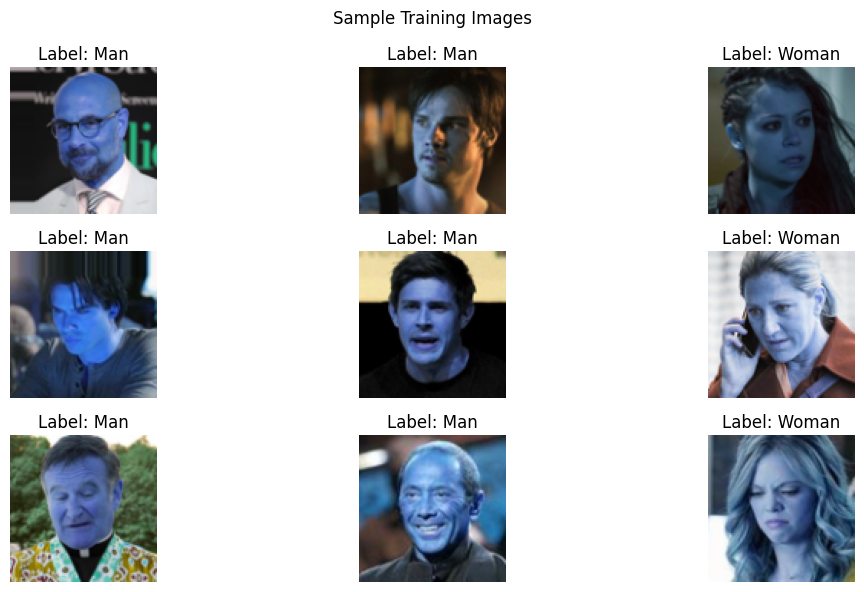

In [6]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(trainX) - 1)
    img = (trainX[idx] + 1) / 2.0  # Rescale from [-1, 1] to [0, 1] for display

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {'Woman' if np.argmax(trainY[idx]) == 1 else 'Man'}")
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.savefig('Images/sample_images.png')
plt.show()

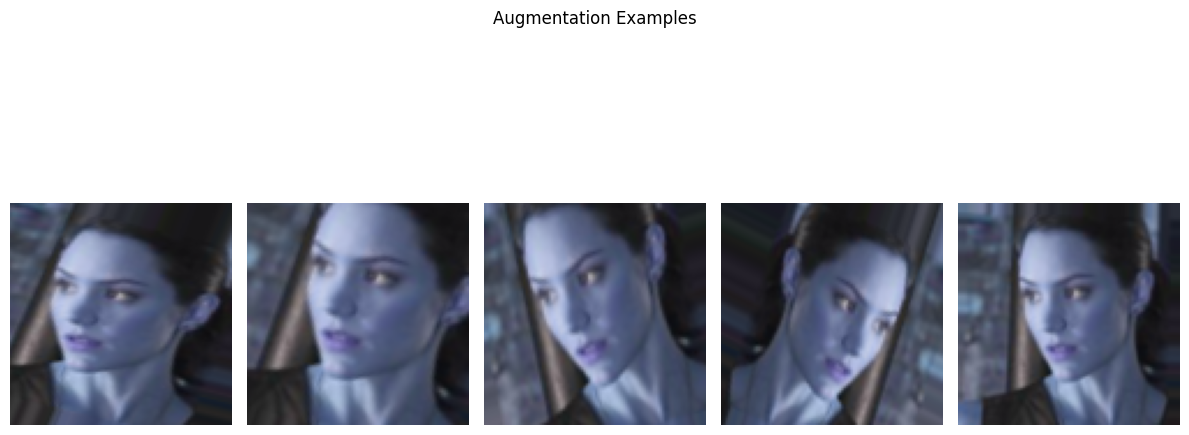

In [7]:
# Augmenting the dataset
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

# Visualize data augmentation
sample_image = trainX[0]
aug_iter = aug.flow(np.expand_dims(sample_image, axis=0), batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_image = next(aug_iter)[0]
    aug_image = (aug_image + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
    plt.imshow(aug_image)
    plt.axis('off')

plt.suptitle("Augmentation Examples")
plt.tight_layout()
plt.savefig('Images/augmented_examples.png')
plt.show()

In [8]:
def build_densenet(input_shape=(128, 128, 3), classes=2):
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [9]:
# Train the model
# Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_model = None
best_fold = -1

for fold, (train_idx, test_idx) in enumerate(skf.split(data, labels)):
    print(f"\n===== Fold {fold + 1}/{n_splits} =====")
    trainX, testX = data[train_idx], data[test_idx]
    trainY, testY = labels[train_idx], labels[test_idx]

    trainY_cat = to_categorical(trainY, num_classes=2)
    testY_cat = to_categorical(testY, num_classes=2)

    # Build and compile the model
    model = build_densenet(input_shape=(img_dims[0], img_dims[1], 3))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    H=model.fit(
        aug.flow(trainX, trainY_cat, batch_size=batch_size),
        validation_data=(testX, testY_cat),
        steps_per_epoch=len(trainX) // batch_size,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate
    predY = model.predict(testX, batch_size=batch_size)
    predY = np.argmax(predY, axis=1)
    trueY = testY

    acc = accuracy_score(trueY, predY)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

    # Save the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_fold = fold + 1

# Save the best model
best_model.save(f'Model/best_gender_detection_densenet_fold{best_fold}.h5')

# Final summary
print(f"\nBest Fold: {best_fold} with Accuracy: {best_accuracy:.4f}")


===== Fold 1/5 =====


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 130s 841ms/step - accuracy: 0.6545 - loss: 1.0113 - val_accuracy: 0.8693 - val_loss: 0.3528
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:26 627ms/step - accuracy: 0.7500 - loss: 0.6087

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.7500 - loss: 0.6087 - val_accuracy: 0.8702 - val_loss: 0.3525
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 112s 808ms/step - accuracy: 0.8029 - loss: 0.5047 - val_accuracy: 0.8702 - val_loss: 0.3177
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.8125 - loss: 0.4074 - val_accuracy: 0.8720 - val_loss: 0.3181
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 112s 806ms/step - accuracy: 0.8191 - loss: 0.4336 - val_accuracy: 0.8783 - val_loss: 0.2992
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.8281 - loss: 0.3150 - val_accuracy: 0.8779 - val_loss: 0.2992
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 119s 857ms/step - accuracy: 0.8298 - loss: 0.3875 - val_accuracy: 0.8779 - val_loss: 0.3010
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.8281 - loss: 0.5117 - val_accuracy: 0.8779 - val_loss: 0.3015
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 127s 911ms/step - accuracy: 0.8502 - loss: 0.3510 -

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_431']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.6554 - loss: 1.0461 - val_accuracy: 0.8559 - val_loss: 0.3536
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:42 741ms/step - accuracy: 0.7812 - loss: 0.4852

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.7812 - loss: 0.4852 - val_accuracy: 0.8554 - val_loss: 0.3541
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 128s 923ms/step - accuracy: 0.8004 - loss: 0.5069 - val_accuracy: 0.8693 - val_loss: 0.3178
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.8594 - loss: 0.3128 - val_accuracy: 0.8698 - val_loss: 0.3197
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 135s 973ms/step - accuracy: 0.8257 - loss: 0.4248 - val_accuracy: 0.8756 - val_loss: 0.3028
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.8281 - loss: 0.3642 - val_accuracy: 0.8747 - val_loss: 0.3024
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 135s 967ms/step - accuracy: 0.8362 - loss: 0.3768 - val_accuracy: 0.8743 - val_loss: 0.2974
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.8125 - loss: 0.3901 - val_accuracy: 0.8743 - val_loss: 0.2971
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 135s 972ms/step - accuracy: 0.8430 - loss: 0.3668 -

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_862']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 132s 853ms/step - accuracy: 0.6768 - loss: 0.9592 - val_accuracy: 0.8541 - val_loss: 0.3519
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:30 659ms/step - accuracy: 0.7812 - loss: 0.5201

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7812 - loss: 0.5201 - val_accuracy: 0.8563 - val_loss: 0.3531
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 121s 872ms/step - accuracy: 0.7990 - loss: 0.5078 - val_accuracy: 0.8644 - val_loss: 0.3226
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7969 - loss: 0.4906 - val_accuracy: 0.8653 - val_loss: 0.3219
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 837ms/step - accuracy: 0.8229 - loss: 0.4265 - val_accuracy: 0.8684 - val_loss: 0.3079
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.8750 - loss: 0.2640 - val_accuracy: 0.8680 - val_loss: 0.3082
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 120s 867ms/step - accuracy: 0.8350 - loss: 0.3940 - val_accuracy: 0.8725 - val_loss: 0.3005
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8438 - loss: 0.4033 - val_accuracy: 0.8725 - val_loss: 0.3006
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 121s 870ms/step - accuracy: 0.8441 - loss: 0.3651 -

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1293']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 142s 915ms/step - accuracy: 0.6862 - loss: 0.8774 - val_accuracy: 0.8693 - val_loss: 0.3401
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:36 702ms/step - accuracy: 0.7969 - loss: 0.5972

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.7969 - loss: 0.5972 - val_accuracy: 0.8707 - val_loss: 0.3404
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 115s 828ms/step - accuracy: 0.7862 - loss: 0.5333 - val_accuracy: 0.8752 - val_loss: 0.3195
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.8438 - loss: 0.3300 - val_accuracy: 0.8747 - val_loss: 0.3193
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 122s 881ms/step - accuracy: 0.8305 - loss: 0.4119 - val_accuracy: 0.8765 - val_loss: 0.3053
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.7969 - loss: 0.4566 - val_accuracy: 0.8765 - val_loss: 0.3053
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 114s 818ms/step - accuracy: 0.8327 - loss: 0.3893 - val_accuracy: 0.8774 - val_loss: 0.3032
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.8281 - loss: 0.4149 - val_accuracy: 0.8783 - val_loss: 0.3027
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 119s 854ms/step - accuracy: 0.8436 - loss: 0.3747 -

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1724']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.6569 - loss: 1.1273 - val_accuracy: 0.8523 - val_loss: 0.3985
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.8438 - loss: 0.5079

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.8438 - loss: 0.5079 - val_accuracy: 0.8514 - val_loss: 0.3947
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7944 - loss: 0.5427 - val_accuracy: 0.8617 - val_loss: 0.3367
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 50s 354ms/step - accuracy: 0.7969 - loss: 0.4361 - val_accuracy: 0.8635 - val_loss: 0.3315
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8234 - loss: 0.4251 - val_accuracy: 0.8756 - val_loss: 0.3032
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 48s 341ms/step - accuracy: 0.8438 - loss: 0.4276 - val_accuracy: 0.8743 - val_loss: 0.3029
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8321 - loss: 0.3933 - val_accuracy: 0.8711 - val_loss: 0.3004
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 335ms/step - accuracy: 0.7031 - loss: 0.7016 - val_accuracy: 0.8716 - val_loss: 0.3012
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8377 - loss: 0.3699 - val_accurac

Fold 5 Accuracy: 0.8765

Best Fold: 1 with Accuracy: 0.8940


In [14]:
# Generate predictions
predY = best_model.predict(testX, batch_size=batch_size)  # Model predictions (probabilities)
predY = np.argmax(predY, axis=1)  # Convert probabilities to class labels
trueY = testY # True labels (binary 0 or 1)

# Compute confusion matrix
cm = confusion_matrix(trueY, predY)

# Extract TP, FP, FN, TN
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

# Compute additional metrics
accuracy = accuracy_score(trueY, predY)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report for more details
print("\nClassification Report:")
print(classification_report(trueY, predY, target_names=["Man", "Woman"]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step
Confusion Matrix:
[[1092   92]
 [ 134  909]]
True Positives (TP): 909
False Positives (FP): 92
False Negatives (FN): 134
True Negatives (TN): 1092
Accuracy: 0.90
Precision: 0.91
Recall: 0.87
F1 Score: 0.89

Classification Report:
              precision    recall  f1-score   support

         Man       0.89      0.92      0.91      1184
       Woman       0.91      0.87      0.89      1043

    accuracy                           0.90      2227
   macro avg       0.90      0.90      0.90      2227
weighted avg       0.90      0.90      0.90      2227



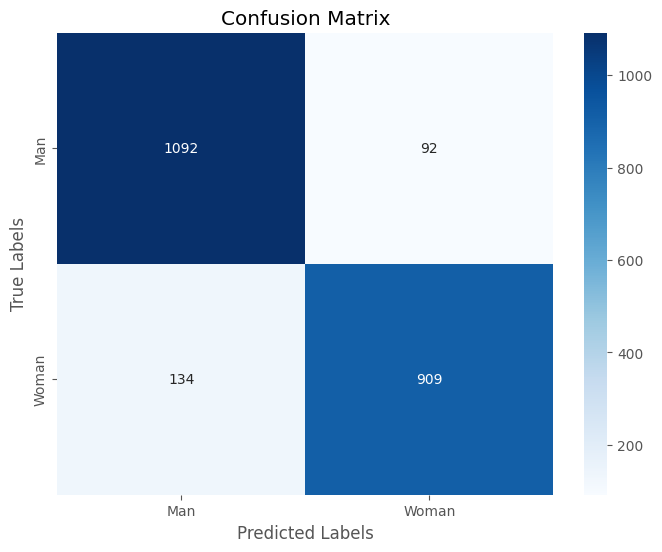

In [15]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Man", "Woman"], yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


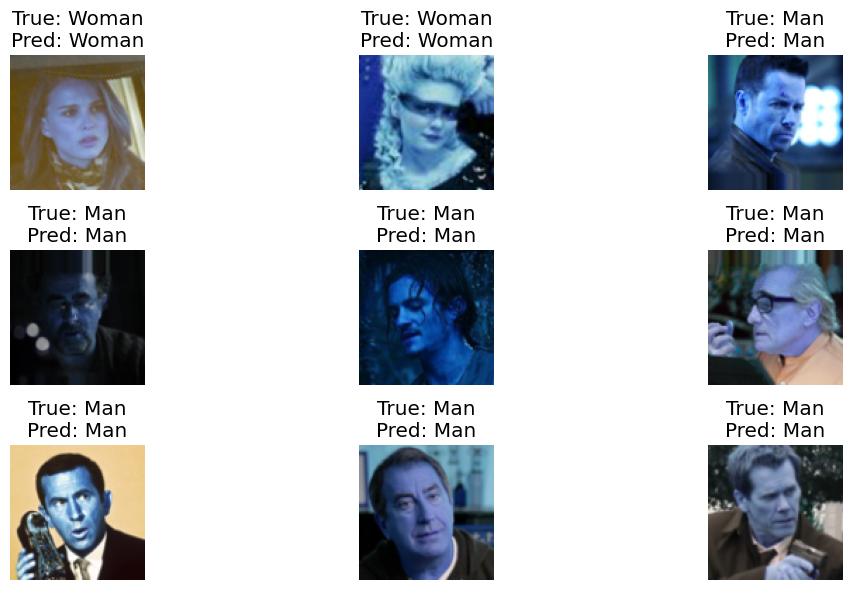

In [16]:
# Display predictions on test images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(testX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow((testX[idx] + 1) / 2)  # Rescale for display
    pred_label = 'Woman' if predY[idx] == 1 else 'Man'
    true_label = 'Woman' if trueY[idx] == 1 else 'Man'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/test_predictions.png')
plt.show()

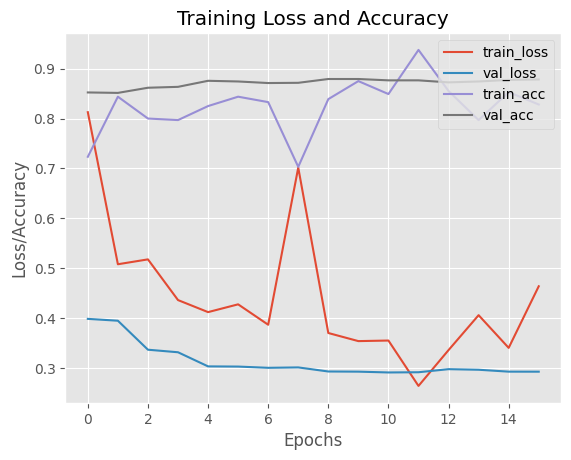

In [17]:
plt.style.use("ggplot")
plt.figure()

N = len(H.history["loss"])  # Actual number of epochs trained
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

plt.savefig('Images/plot.png')
